在回归问题中,我们的目的是输出价格或者概率这样连续的值,而对于分类问题,我们目的是输出一个分类

In [1]:
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 获取数据

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/yudd/.keras/datasets/auto-mpg.data'

使用pandas导入数据

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t", sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 数据清洗

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# 简单的删除这些行
dataset = dataset.dropna()

而`Origin` 列对应的是分类,而不是一个数字,所以将其用`one-hot`转化

In [6]:
origin = dataset.pop("Origin")

In [7]:
# 讲origin转化为不同分类
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin ==2) * 1.0
dataset["Japan"] = (origin == 3)*1.0

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 拆分训练数据集和测试数据集

In [8]:
train_dataset = dataset.sample(frac = 0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

##  查看数据

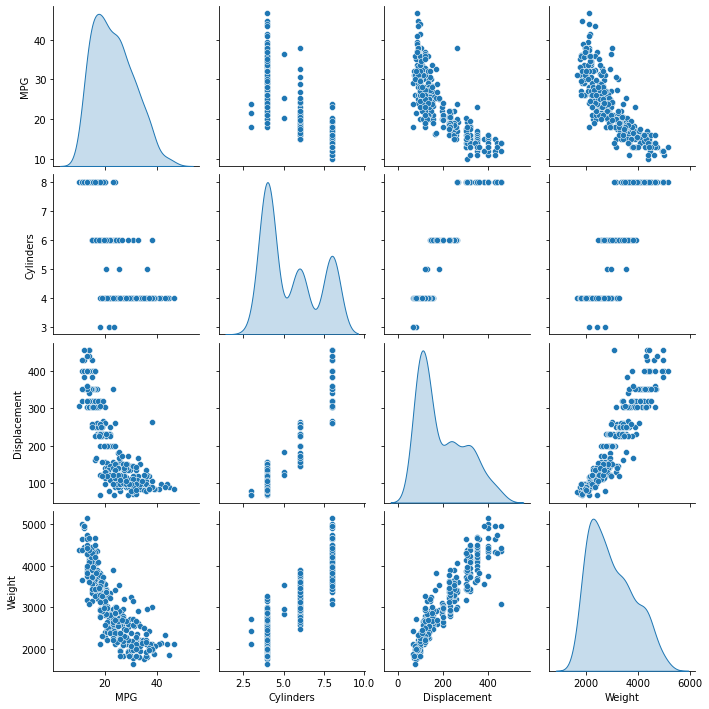

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders",
                           "Displacement", "Weight"]],
            diag_kind="kde")

也可以查看总体的数据统计

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose() # 转置
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [11]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

## 数据的规范化

In [12]:
# 将每一个特征的范围进行归一化
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


In [14]:
train_dataset.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0


## 构建模型

In [15]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation = "relu"),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = "mse",
                 optimizer = optimizer,
                 metrics=["mae", "mse"])
    
    return model

In [16]:
model = build_model()

2021-08-03 23:06:51.760923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 查看模型

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


试一下这个模型,从训练数据中获取10条例子

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

2021-08-03 23:06:51.869216: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


array([[-0.39957967],
       [-0.13112874],
       [ 0.10571969],
       [ 0.04513276],
       [ 0.18484068],
       [ 0.00959787],
       [ 0.17224747],
       [ 0.06109884],
       [-0.09196163],
       [-0.00876419]], dtype=float32)

## 训练模型

对模型进行1000个周期的训练,并在history对象中记录训练和验证的准确性.

In [19]:
# 通过为每个完成的时期打印一个点来现实训练进度

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print("")
        print(".", end="")
        
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS,
    validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]

)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

可视化模型的训练进度

In [20]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.293947,0.970273,2.293947,10.320619,2.577296,10.320619,995
996,2.361649,0.979266,2.361649,9.659138,2.438808,9.659138,996
997,2.414158,0.970776,2.414158,10.311831,2.450722,10.311831,997
998,2.546371,1.048868,2.546371,10.346569,2.462876,10.346569,998
999,2.422201,1.013204,2.422201,10.247895,2.445394,10.247895,999


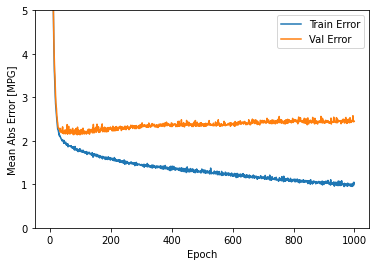

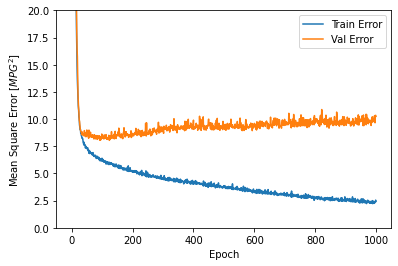

In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [MPG]")
    plt.plot(hist["epoch"], hist["mae"],
            label = "Train Error")
    plt.plot(hist["epoch"], hist["val_mae"],
            label = "Val Error")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

    
    
plot_history(history)

可以看到模型反而出现了恶化, 我们进行一些改进


.................................................................

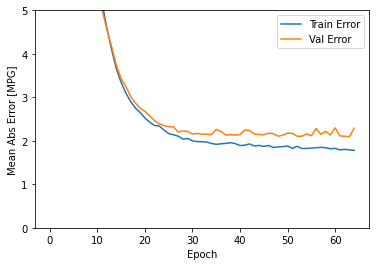

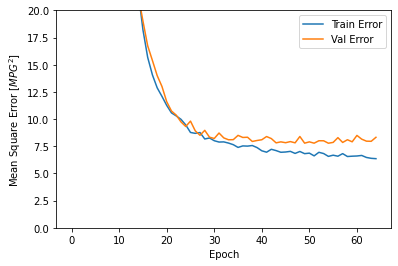

In [25]:
model = build_model()

# patience 值用来检查改进epochs的数量
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=10)
history = model.fit(normed_train_data, train_labels, 
                   epochs=EPOCHS,
                   validation_split = 0.2,
                   verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

下面用**测试集**来泛化模型的效果

In [26]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels)


print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 [==============================] - 0s 2ms/step - loss: 6.0257 - mae: 1.8443 - mse: 6.0257
Testing set Mean Abs Error:  1.84 MPG


## prediction

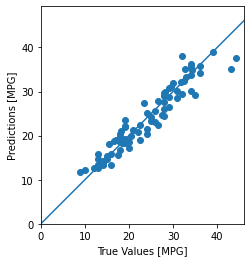

In [35]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
# normed_test_data.head()

检查误差分布

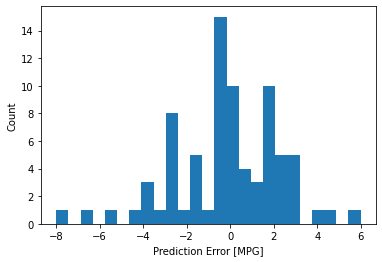

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_= plt.ylabel("Count")

* 均方误差(mse)是常见的回归问题的损失函数
* 常见的回归指标是平均绝对误差
* 如果训练数据不多,一种方法是选择隐藏层较小的小网络
* 早起停止可以防止过拟合